In [1]:
#from AudioFeatures import *
#from AudioFeatures import load_pickle as lp
import scipy
from scipy import io
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import IPython.display as ipd
import h5py, os, pickle, re

init_notebook_mode(connected=True) # set plotly to work in notebook mode
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


## Load data

In [3]:
features = './activations.mat'
f = h5py.File(features)

In [4]:
activations = f['fc_1_activations'][()]

In [5]:
activations.shape

(15000, 1024)

In [6]:
label_mat = features[:-5]+'_labels.mat'
labels_files = scipy.io.loadmat(label_mat, chars_as_strings=True)

In [7]:
labels = labels_files['labels']
labels = np.array([l.rstrip() for l in labels])
labels.shape

(15000,)

In [8]:
files = labels_files['files']
files.shape

(15000,)

In [9]:
def clean_file_names(x):
    x = os.path.basename(x)
    x = x.strip()
    x = x[:-4]
    return x

files = [clean_file_names(x) for x in files]

Create pandas Dataframes

In [10]:
D = pd.DataFrame(activations)
df_files = pd.DataFrame(files)

## Pre-processing of Data

Scale the activations to have approximately zero mean and unit variance for analysis.

In [11]:
scaler = StandardScaler()

D_norm = scaler.fit_transform(D)
D_norm = pd.DataFrame(D_norm)

In [12]:
D_norm.shape

(15000, 1024)

## t-SNE

In [13]:
try:
    # Try to retrieve the dataset from existing CSV
    D_tsne = np.loadtxt(open("./tsne.csv", "rb"), delimiter=",")
    
    print("t-SNE was already computed and retrieved from stored CSV")
    
except:
    # Compute t-SNE
    t_sne = TSNE(n_components=3, init='pca', random_state=0, verbose=2)
    D_tsne = t_sne.fit_transform(D_norm)
    
    # Save the result
    np.savetxt("./tsne.csv", D_tsne, delimiter=",")
    
    print("t-SNE just computed has been stored in a CSV file for future retrieve")

t-SNE was already computed and retrieved from stored CSV


In [14]:
D_tsne.shape

(15000, 3)

In [15]:
def plot_tsne(df, labels, title=""):
    """
    Plot the t-SNE embedding
    
    Positional arguments:
        df - t-SNE fitted data
        labels - labels corresponding to df
    """
    unique_labels = np.unique(labels)
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'SaddleBrown', 'SlateGrey', 'DarkOrange']
    
    for i in range(len(unique_labels)):
        # Mask and filter the array
        m = labels==unique_labels[i]
        m_df = df[m]

        # Draw the points
        plt.scatter(m_df[:,0], m_df[:,1], label=unique_labels[i], alpha=0.5, color=colors[i], marker='.')
        
    plt.legend(ncol=2, scatterpoints=1)
    plt.xlabel("First Component")
    plt.ylabel("Second Component")
    plt.title("Data Projection into 2D Subspace - t-SNE{}".format(title))

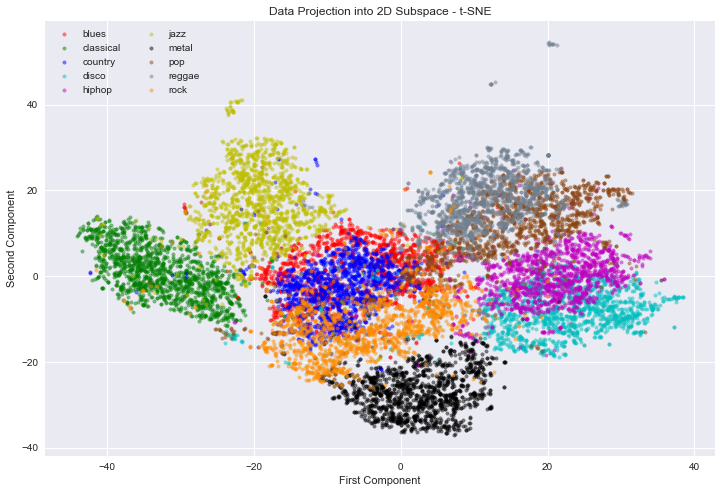

In [16]:
plot_tsne(D_tsne, labels)

In [17]:
D_tsne.shape

(15000, 3)

In [18]:
labels == np.unique(labels)[1]

array([False, False, False, ..., False, False, False], dtype=bool)

In [49]:
track_id = []
with open('GTZANindex_reformat.txt') as f:
    for line in f:
        if line[0]=='#':
            pass
        else:
            for _ in range(15):
                track_id.append(line)

In [38]:
def plotly_3d(df, labels, files, eigens=None):
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # List to hold traces per label
    traces = [None]*len(unique_labels)
    
    for i in range(len(unique_labels)):
        # Mask and filter the array
        m = labels==unique_labels[i]
        m_df = df[m]
        m_files=pd.DataFrame(files)
        m_files=m_files[m]
        
        # Project the data and create trace
        traces[i] = go.Scatter3d(
            x=m_df[:,0],
            y=m_df[:,1],
            z=m_df[:,2],
            name=unique_labels[i],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            ),
            text=m_files[0].tolist()
        )
        
    layout = go.Layout(
        title='Data projection into 3D subspace - t-SNE',
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

In [39]:
plotly_3d(D_tsne, labels, track_id)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Collate activations data into whole tracks and revisualise

In [40]:
np.mean(activations[:15,:], axis=0)

array([ 6.18661451,  2.66026092,  5.14621592, ...,  0.01503384,
       -0.02061296,  0.90928066], dtype=float32)

In [41]:
def collate_tracks(segments, function):
    activ_coll = []
    start = 0
    stop = 15

    while start < len(activations):
        activ_coll.append(
            function(activations[start:stop,:], axis=0)
        )

        start+=15
        stop+=15
        
    return np.array(activ_coll)

D_coll_mean = collate_tracks(D_norm, np.mean)

D_coll_mean.shape

(1000, 1024)

In [42]:
try:
    # Try to retrieve the dataset from existing CSV
    D_coll_mean_tsne = np.loadtxt(open("./coll_mean_tsne.csv", "rb"), delimiter=",")
    
    print("t-SNE was already computed and retrieved from stored CSV")
    
except:
    # Compute t-SNE
    t_sne = TSNE(n_components=3, init='pca', random_state=0)
    D_coll_mean_tsne = t_sne.fit_transform(D_coll_mean)
    
    # Save the result
    np.savetxt("./coll_mean_tsne.csv", D_coll_mean_tsne, delimiter=",")
    
    print("t-SNE just computed has been stored in a CSV file for future retrieve")

t-SNE was already computed and retrieved from stored CSV


In [43]:
D_coll_mean_tsne

array([[-13.02797604,   9.43387508, -24.79488945],
       [-17.21749306,   2.64719367, -15.77693367],
       [-12.29394436,   6.09248829, -24.74178505],
       ..., 
       [  5.96631813, -31.02645683,  13.76467705],
       [ -4.9675951 , -13.31019688,  16.917799  ],
       [  9.82027054, -21.2915535 ,  12.50170898]])

In [50]:
coll_labels = []
for i in range(len(labels)):
    if i%15==0:
        coll_labels.append(labels[i])
        
coll_labels = np.array(coll_labels)

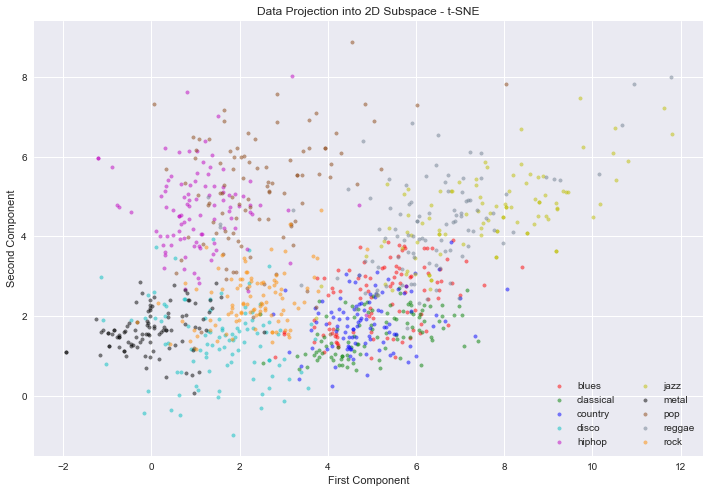

In [51]:
plot_tsne(D_coll_mean, coll_labels)

In [52]:
coll_track_id = []
for i in range(len(track_id)):
    if i%15==0:
        coll_track_id.append(track_id[i])
    
coll_track_id = np.array(coll_track_id)

In [53]:
plotly_3d(D_coll_mean, coll_labels, coll_track_id)

In [30]:
coll_labels_mat = coll_labels[:, np.newaxis]

D_coll_mean_tsne_extended = np.hstack((coll_labels_mat, D_coll_mean_tsne))

D_coll_mean_tsne_extended.shape

(1000, 4)

In [31]:
d = pd.DataFrame(D_coll_mean_tsne_extended, columns=['label', 'x', 'y', 'z'])
d.to_csv("./coll_mean_tsne_extended.csv", sep=',', index=False, header=True)

In [32]:
type(d['x'][0])

str

In [33]:
d[['x','y', 'z']] = d[['x','y', 'z']].apply(pd.to_numeric)

In [34]:
type(d['x'][0])

numpy.float64

In [35]:
d.describe()

,x,y,z
count,1000.000000,1000.000000,1000.000000
mean,-0.897887,-0.446606,-0.240651
std,26.763909,21.367362,14.889871
min,-62.816620,-53.697475,-36.459034
25%,-17.927566,-12.443851,-12.138299
50%,3.350974,-1.005019,0.489796
75%,19.588483,15.210020,13.201451
max,48.023880,43.919456,25.892881


In [62]:
tracks_raw = pd.DataFrame(coll_track_id, columns=['track'])
#tracks.to_csv("./tracks.csv", sep=',', index=False, header=True)

In [63]:
all_rows = []
for index, row in tracks_raw.iterrows():
    s = row['track']
    file_path = s[s.find("(")+1:s.find(")")]
    track = s[s.find(")")+1:]
    all_rows.append({'path': file_path, 'track':track})

tracks = pd.DataFrame(all_rows)
tracks.to_csv("./tracks.csv", sep=',', index=False, header=True)